In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
from endgame import hist2d

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [4]:
# those three are created from storm cut out kernels (storm netcdf files needed!)

#OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA5_5-20N.p', 'rb'))
#OBS3 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-40_zeroRain_gt5k_-40thresh_OBSera.p', 'rb'))
#OBS = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_TRMM_ERA-I.p', 'rb'))
OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA-I.p', 'rb'))
#OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA5_5-20N.p', 'rb'))

In [5]:
OBS2.keys()

dict_keys(['pmean', 'pgt30', 'shear', 'month', 'w925', 'tmean', 'pmax', 'q650', 'hour', 'clon', 'year', 'rh925', 'pv650', 'area', 'v650', 'clat', 'div925', 'rh650', 'tmin', 'w650', 'v925', 'pv925', 't', 'lat', 'p', 'u650', 'div650', 'pgt01isvalid', 'lon', 'q925', 'u925', 't925', 't650'])

In [6]:
def create_dic(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])
    umax = np.array(dic['u925'])
    qq = np.array(dic['q925']) 
    qup = np.array(dic['q650'])
    tup = np.array(dic['t650'])
    tlow = np.array(dic['t925'])
    rh650 = np.array(dic['rh650'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    year = np.array(dic['year'])
    
    thetae_up = u_met.theta_e(650, tup-273.15, qup)
    thetae_down = u_met.theta_e(925, tlow-273.15, qq)
    
    thetae = thetae_down - thetae_up
    
    theta_up = u_met.theta(650, tup-273.15)
    theta_down = u_met.theta(925, tlow-273.15)
    
    theta = theta_down - theta_up

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        't650' : tup-273.15,
        'rh650' : rh650,
        'shear' : sh*-1,
        'month' : month,
        'year' : year,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'theta' : theta,
        'theta_e' : thetae,
        'lat' : lat,
        'lon' : lon,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs

In [7]:

obs_gpm= create_dic(OBS2)


In [8]:
np.max(obs_gpm.lat)

8.785011408437857

In [9]:

obs_gpm = obs_gpm[(obs_gpm.lon>=-12)&(obs_gpm.lon<=12)&(obs_gpm.lat>=5)&(obs_gpm.lat<=8.5) & (obs_gpm.month<=11)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]



In [10]:

print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

OBS_gpm 5.000244249749977 8.499993709315941 -11.863580727713256 11.796071028573365


In [11]:
obs_gpm.keys()

Index(['prcp', 'u650', 'u925', 'q925', 'q650', 't925', 't650', 'rh650',
       'shear', 'month', 'year', 'area', 'tmin', 'tmean', 'theta', 'theta_e',
       'lat', 'lon'],
      dtype='object')

In [12]:
np.unique(obs_gpm.year)

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

In [13]:
aarea = pkl.load(open('/home/ck/DIR/cornkle/data/CLOVER/saves/storm_area_10W-12E_5-8N_-75C_5000km2_18.p','rb'))


In [14]:
aarea[2]

[[237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [237, 91],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [184, 234, 205, 655, 157, 121],
 [18

In [15]:
eighties = obs_gpm[obs_gpm.year]

KeyError: "None of [Int64Index([2007, 2012, 2011, 2007, 2014, 2014, 2004, 2013, 2009, 2010,\n            ...\n            2004, 2014, 2010, 2011, 2004, 2010, 2013, 2004, 2014, 2013],\n           dtype='int64', length=17528)] are in the [columns]"

Text(0.5,1,'-0.56')

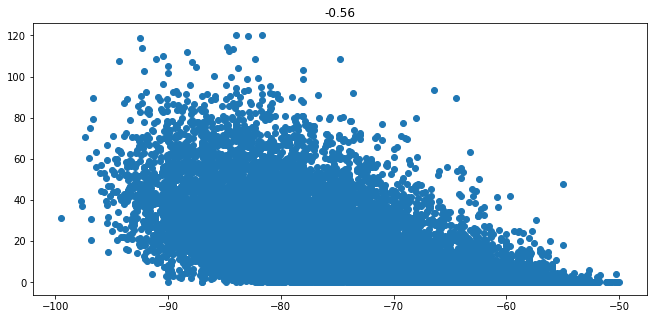

In [16]:

cp4s = [obs_gpm.tmin, obs_gpm.prcp] # gpm



f = plt.figure(figsize=(11,5))
ax = f.add_subplot(111)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

#ax.set_ylim(0,150)
#ax.set_ylim(13,19)


Text(0.5,1,'0.01')

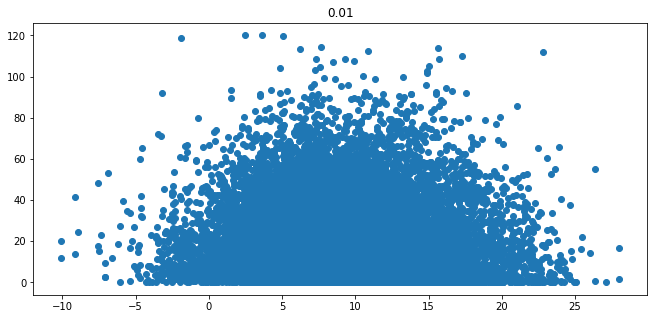

In [19]:
cp4s = [obs_gpm.theta_e, obs_gpm.prcp] # gpm



f = plt.figure(figsize=(11,5))
ax = f.add_subplot(111)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

#ax.set_ylim(0,150)
#ax.set_ylim(13,19)

In [20]:
histo = hist2d.perc_1d_binning(obs_gpm.prcp, obs_gpm.theta_e, np.arange(5,26,1), 50)

In [21]:
histo

{'data': [12.187311128335852,
  13.15141064044185,
  14.085781329973438,
  12.538887604113157,
  13.40596400531518,
  14.166860510183321,
  13.936182803564572,
  15.507405996609219,
  14.472869819039577,
  12.934885636737569,
  11.240613008900898,
  12.594698887209926,
  14.22609133340368,
  13.281631266186082,
  13.112612895364439,
  10.635229821020458,
  14.493554474367905,
  9.855330825371597,
  6.334416735189349,
  5.641417181821133],
 'xbins': array([ 5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5,
        16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5, 23.5, 24.5])}

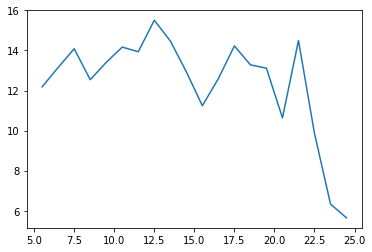

In [22]:
plt.plot(histo['xbins'], histo['data'])

In [23]:
pl = []
for m in range(2,12):
    try:
        dat = obs_gpm[obs_gpm.month==m]
        out = np.percentile(np.array(dat['prcp'])[dat['prcp']>1], 98)
    except:
        continue
    print(m,out)
    pl.append(out)

3 64.91667687515955
4 70.92881951226369
5 78.15756938761096
6 75.60648946636641
7 68.66460424726787
8 60.29570834787505
9 63.90079744272004
10 62.714315003581746
11 59.96742876019523


In [24]:

print(obs_gpm.area.min())


4400


In [25]:
oposi = (obs_gpm.u650<0) & (obs_gpm.area>=5000) & (obs_gpm.prcp>=5) & (obs_gpm.tmin<=-70) & (obs_gpm.q925>=12) 

In [26]:
obs_gpm

,prcp,u650,u925,q925,q650,t925,t650,rh650,shear,month,year,area,tmin,tmean,theta,theta_e,lat,lon
0,16.436291,-0.871464,3.370841,14.771931,6.616410,20.572961,5.643030,75.409485,4.242306,7,2007,15175,-66.000000,-59.368354,-15.001330,3.964162,8.042260,7.086056
1,4.185770,3.606708,2.738187,16.826462,7.055621,21.302759,5.181268,82.557541,-0.868521,8,2012,8625,-68.415718,-59.640201,-13.732772,9.224508,5.251607,11.170472
2,25.979994,-4.892231,1.005554,15.512910,1.884424,23.212488,5.504205,21.571932,5.897785,11,2011,5050,-76.043866,-63.932756,-12.145262,22.025579,6.118873,-0.763059
3,4.442560,-2.469631,2.000826,16.180061,7.242737,20.370538,5.093530,85.357971,4.470457,9,2007,7625,-61.784279,-55.328215,-14.586770,6.198932,7.318028,-11.432332
4,16.874041,-1.495301,0.240639,15.085265,8.860437,20.655878,5.881128,98.025848,1.735940,8,2014,12700,-71.352158,-57.706569,-15.185860,-1.739625,5.550144,11.265918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19095,4.857432,-6.564244,0.027917,14.565083,6.717112,24.014551,6.045984,75.579094,6.592162,6,2010,25450,-68.000000,-59.528910,-11.937929,6.217744,6.473726,11.480790
19096,2.147364,-11.520764,-0.617962,15.386011,4.537384,21.409753,6.298578,49.201180,10.902802,11,2013,16225,-70.565518,-60.558292,-14.887171,11.493083,5.181355,5.927033
19097,12.610687,-10.356858,1.832192,15.191071,4.790841,20.323297,4.502588,59.545422,12.189051,6,2004,5725,-67.479596,-57.966965,-13.966652,11.204103,7.197307,-10.971910
19098,0.068028,-4.384125,0.543739,16.076978,5.591696,21.920679,6.662958,59.368275,4.927864,5,2014,5600,-84.836750,-66.987397,-14.776881,10.393933,7.468928,-8.730018


In [27]:

obsp = obs_gpm[oposi]

In [28]:
obsp.keys()

Index(['prcp', 'u650', 'u925', 'q925', 'q650', 't925', 't650', 'rh650',
       'shear', 'month', 'year', 'area', 'tmin', 'tmean', 'theta', 'theta_e',
       'lat', 'lon'],
      dtype='object')

In [29]:
len(obsp)

10308

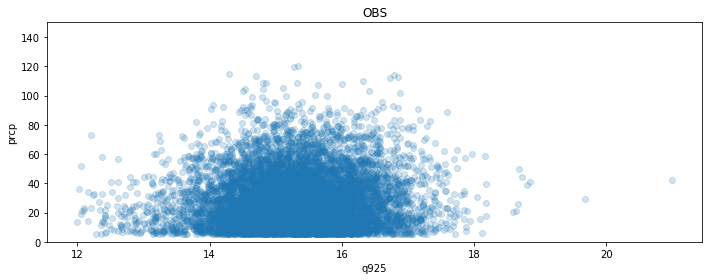

In [30]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).q925, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

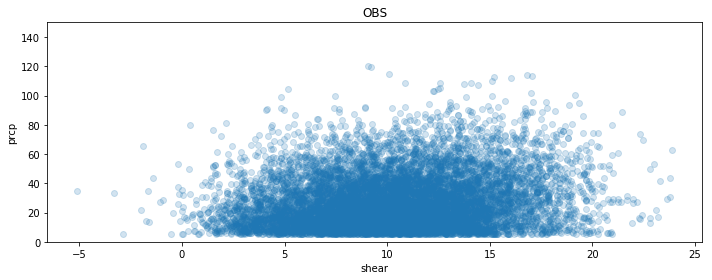

In [31]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).shear, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('shear')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

In [32]:
print(obsp['q925'].median())
print(obsp['shear'].median())
print(obsp['prcp'].median())
print(obsp['tmin'].median())
print(obsp['theta_e'].median())

15.268468298017979
10.198507308959961
22.925846714122475
-79.45807105299215
9.243683048246794


In [33]:
print(obsp['q925'].mean())
print(obsp['shear'].mean())
print(obsp['prcp'].mean())
print(obsp['tmin'].mean())
print(obsp['theta_e'].mean())

15.281439848373571
10.277938735915285
27.354121990410622
-79.80181446797032
9.54204411890446


In [67]:
alln=7
nbs= alln
nbq= alln
nba = alln

p1 = 1 #5
p2 = 99

shearb_march = np.percentile(obsp.shear[(obsp.shear>=np.percentile(obsp.shear,p1)) & (obsp.shear<=np.percentile(obsp.shear,p2))], np.linspace(0,100,nbs)) #np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))

# shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
# shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
# shear25_march = np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))

abins = np.linspace(5000,250000, nba)
#qbinsb_march = np.linspace(np.percentile(obsp.q925, 1) , np.percentile(obsp.q925, p2), nbq) 

nbqq = 9
nbss = 9

p1 = 1
p2 = 99

#shear_obsp = np.percentile(obsp.shear[(obsp.shear>=np.percentile(obsp.shear,p1)) & (obsp.shear<=np.percentile(obsp.shear,p2))], np.linspace(0,100,nbss)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))
#np.percentile(obsp.shear[(obsp.shear>=3) & (obsp.shear<=17)], np.linspace(0,100,nbss))

qbinso = np.linspace(np.percentile(obsp.q925,2) , np.percentile(obsp.q925, p2), nbqq)
#qbinso = np.linspace(np.percentile(obsp.rh650,p1) , np.percentile(obsp.rh650, p2), nbqq)
#qbinso = np.linspace(np.percentile(obsp.theta_e,p1) , np.percentile(obsp.theta_e, p2), nbqq)
shear_obsp = np.linspace(np.percentile(obsp.shear, p1) , np.percentile(obsp.shear, p2), nbss)


In [68]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mean = np.nanmean(ds.tmin[poss_ds])#np.percentile(ds.tmin[poss_ds], 95) #np.nanmean(ds.tmin[poss_ds])# 
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.nanmean(ds.prcp[poss_ds]) # np.percentile(ds.prcp[poss_ds], 95) #np.nanmean(ds.prcp[poss_ds]) ## np.nanmean(ds.prcp[poss_ds]) 
            except:
                prcp_mean = np.nan

            try:
                ds_amean = np.percentile(ds.area[poss_ds], 50)
            except IndexError:
                ds_amean = np.nan

            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outarea_ds, outval

In [69]:
def hist2d_plot(data,xbins, ybins, vmin, vmax, valid=None):
    f = plt.figure()
    ax5 = f.add_subplot(111)
    X, Y = np.meshgrid(xbins,ybins)
    cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
    if valid is not None:
        data[valid<10] = np.nan
    Zm = ma.masked_where(np.isnan(data),data)

    mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=vmin, vmax=vmax) # viridis_rvmin=20, vmax=40
    #mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp) # viridis_rvmin=20, vmax=40

    ax5.set_ylabel('Max. q925hPa')
    ax5.set_xlabel('Max. u925hPa (equally populated)')
    ax5.set_title('')
    cbar = f.colorbar(mappable, ticks=np.linspace(vmin,vmax,9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
    cbar.set_label('90th centile max. rain')
    plt.show()

In [70]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 

In [71]:
def hist2d_six(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,3,i+1)
        if i>2:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<25] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
   # plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_pcp.png')

In [72]:
def hist2d_two(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(12,5))
    for i, dat in enumerate(data):
        ax = f.add_subplot(1,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)

    plt.tight_layout() 
  #  plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_obsOnly.png')

In [73]:
cpobsperc, pcobs, obsarea, obsval = create_2dhist(obsp, shear_obsp, qbinso)

In [74]:
print(len(obsp))

10308


In [93]:
# tmin_dic = {
#     'data' : dsperc_mar,
#     'ybins' : qbinsb_march,
#     'xbins' : shearb_march,
#     'title' : 'Median minimum temperature',
#     'valid' : dsval_mar,
#     'cbarlabel' : '${\circ}$C',
#     'vmin' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],1),
#     'vmax' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],99),
#     'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
#     'xlabel' : 'Wind shear (m s$^{-1}$)'
# }


tmin_dic = {
    'data' : cpobsperc,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Average minimum temperature',
    'valid' : obsval,
    'cbarlabel' : '${\circ}$C',
    'vmin' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],1),
    'vmax' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

pcobs[pcobs==0]=np.nan
prcp_dic = {
    'data' : pcobs,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Average maximum precipitation',
    'valid' : obsval,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],1),
    'vmax' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}



In [94]:
shearscat = np.repeat(shear_obsp,pcobs.shape[0],axis=0).reshape(pcobs.shape)

In [95]:
deltaPS = []
deltaQPS = []
sboxplot = []
tminbox = []
for sh in np.unique(shearscat):
        
        vals = pcobs[sh==shearscat]
        tvals = cpobsperc[sh==shearscat]
        deltaPS.append(np.nanmax(vals)-np.nanmin(vals))
        try:
            deltaQPS.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
        except:
            deltaQPS.append(np.nan)
        sboxplot.append(vals)
        tminbox.append(tvals)
print(np.median(np.array(deltaQPS)[np.isfinite(np.array(deltaQPS))]))

1.533528653979209


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':


9
9


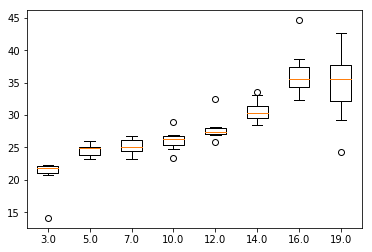

In [96]:
scoll = []
scollbins = np.round(np.unique(shearscat),2)
scollbins = np.round(scollbins[0:-1]+((scollbins[1::]-scollbins[0:-1])/2),0)
for b in sboxplot:
    scoll.append(b[np.isfinite(b)])
print(len(scoll))
print(len(np.unique(shearscat)))
ax = plt.boxplot(scoll[0:-1], labels=scollbins, whis=1)
box1= (scoll[0:-1],scollbins)

/home/ck/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1874: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/home/ck/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1881: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/home/ck/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1889: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/home/ck/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1890: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


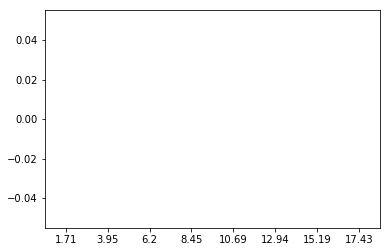

In [97]:
coll = []
for b in tminbox:
    coll.append(b[b!=0])
ax = plt.boxplot(coll[0:-1], labels=np.round(np.unique(shearscat),2)[0:-1])

0.946436309066865
0.8327427803017238


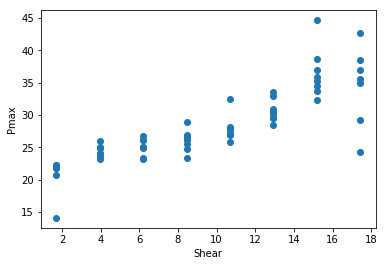

In [98]:
plt.scatter(shearscat, pcobs)
plt.xlabel('Shear')
plt.ylabel('Pmax')
shearfin = shearscat[np.isfinite(pcobs)]
pfin = pcobs[np.isfinite(pcobs)]
slope, intercept, r_value, p_value, std_err = stats.linregress(shearfin, pfin)
print(slope)
print(r_value)

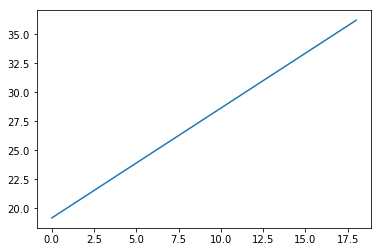

In [99]:
plt.plot(intercept+slope*range(19))

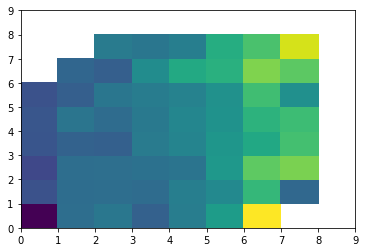

In [100]:
plt.pcolormesh(pcobs.T)

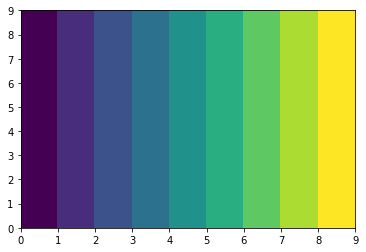

In [101]:
plt.pcolormesh(shearscat.T)

1.2577193333505918
0.23922456614122675


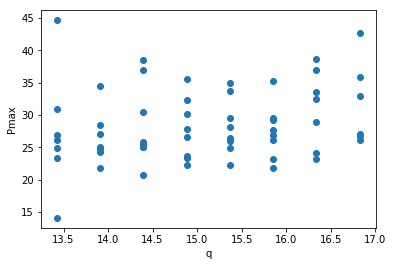

In [102]:
qscat = np.repeat(qbinso[np.newaxis,:],pcobs.shape[0],axis=0).reshape(pcobs.shape)
plt.scatter(qscat, pcobs)
plt.xlabel('q')
plt.ylabel('Pmax')
qfin = qscat[np.isfinite(pcobs)]
pfin = pcobs[np.isfinite(pcobs)]
qslope, qintercept, qr_value, qp_value, qstd_err = stats.linregress(qfin, pfin)
print(qslope)
print(qr_value)

In [103]:
deltaPQ = []
deltaQPQ = []
boxplotq = []
tminboxq = []
for qr in np.unique(qscat):
        
        vals = pcobs[qr==qscat]
        tvals = cpobsperc[qr==qscat]
        deltaPQ.append(np.nanmax(vals)-np.nanmin(vals))
        try:
            deltaQPQ.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
        except:
            deltaQPQ.append(np.nan)
        boxplotq.append(vals)
        tminboxq.append(tvals)
print(np.median(np.array(deltaQPQ)[np.isfinite(np.array(deltaQPQ))]))

5.946123630774611


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':


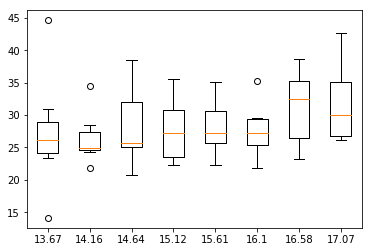

In [104]:
coll = []
qcollbins = np.round(np.unique(qscat),2)
qcollbins = np.round(qcollbins[0:-1]+((qcollbins[1::]-qcollbins[0:-1])/2),2)
for b in boxplotq:
    coll.append(b[np.isfinite(b)])
ax = plt.boxplot(coll[0:-1], labels=qcollbins, whis=1)
box2= (coll[0:-1],qcollbins)

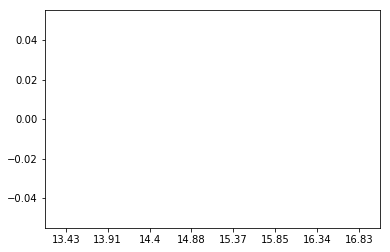

In [105]:
coll = []
for b in tminboxq:
    coll.append(b[b!=0])
ax = plt.boxplot(coll[0:-1], labels=np.round(np.unique(qscat),2)[0:-1])

In [106]:
print(qslope)
print(slope)

1.2577193333505918
0.946436309066865


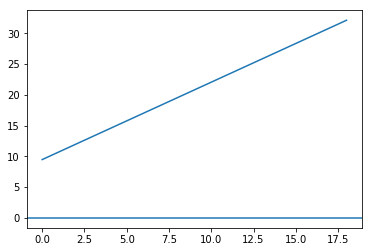

In [107]:
plt.plot(qintercept+qslope*range(19))
plt.axhline(0)

In [108]:
sensitivity = {}
sensitivity['shear_slope'] = slope
sensitivity['qslope'] = qslope 
#pkl.dump(sensitivity, open(cnst.CLOVER_SAVES + 'q_shear_sensitivity_slopes', 'wb'))

In [109]:
data_list = [tmin_dic, prcp_dic]

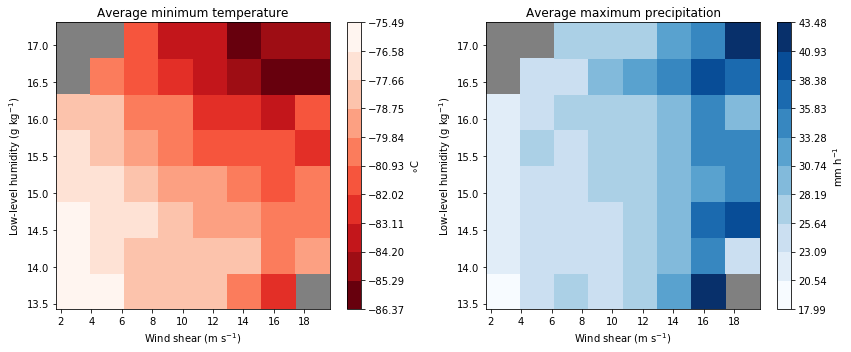

In [110]:
hist2d_two(data_list, valid=True)

99 percentile precip >1 62.748609280492445
[ 3.90488259  8.11199384  9.64118385 10.81855804 11.78164638 12.76456451
 13.64636923 14.69372319 16.00168722 17.58272836 21.47059486]
bigger than 3.9048825931549067
smaller than 8.11199383544922
bigger than 8.11199383544922
smaller than 9.641183853149414
bigger than 9.641183853149414
smaller than 10.818558044433594
bigger than 10.818558044433594
smaller than 11.781646377563476
bigger than 11.781646377563476
smaller than 12.764564514160156
bigger than 12.764564514160156
smaller than 13.646369232177737
bigger than 13.646369232177737
smaller than 14.693723190307617
bigger than 14.693723190307617
smaller than 16.0016872215271
bigger than 16.0016872215271
smaller than 17.58272836303711
bigger than 17.58272836303711
smaller than 21.4705948638916


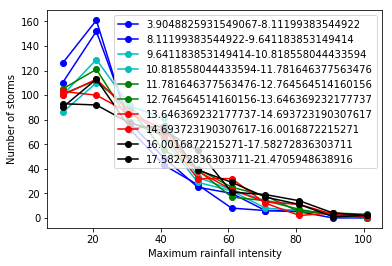

In [730]:
p = np.array(obsp.shear)
t = np.array(obsp.prcp)
q = np.array(obsp.q925)

print('99 percentile precip >1', np.percentile(t[t>1],95))


bins = np.percentile(p[p>=2], np.linspace(1,99,11))#np.arange(4, 29, 2)  # compute probability per temperature range (1degC)
print(bins)
shearlist = []
pprob = []
qqprob = []
plist = []
#ax5 = fig.add_subplot(236)

colours = [ 'b', 'b',  'c', 'c', 'g', 'g', 'r', 'r', 'k', 'k']

for ids, c in enumerate(bins[0:-1]):
    pos = np.where((p >= c) & (p < bins[ids+1]))
    print('bigger than',c )
    print('smaller than', bins[ids+1])

    try:
        cmean = np.percentile(t[pos], 50)
    except IndexError:
        cmean = np.nan

    H, binz = np.histogram(t[pos], bins=np.arange(1,111,10))
    #H, bins = ustat.histo_frequency(t[pos])

    plt.plot(binz[0:-1]+(binz[1::]-binz[0:-1]), H, 'o-',  label=str(c)+'-'+str(bins[ids+1]) , color=colours[ids])

    prob = np.sum(t[pos]>=58) / np.sum(t[pos]>=1)*100
    qprob = np.sum(q[pos]>=17.5) / np.sum(q[pos]>=12)
    pprob.append(prob)
    qqprob.append(qprob)
    plist.append(cmean)
    shearlist.append(((bins[ids+1])-c)/2)

plt.xlabel('Maximum rainfall intensity')
plt.ylabel('Number of storms')
plt.plot()
plt.legend()
xtick = bins[0:-1]

xtickwidth= (bins[1::]-bins[0:-1])

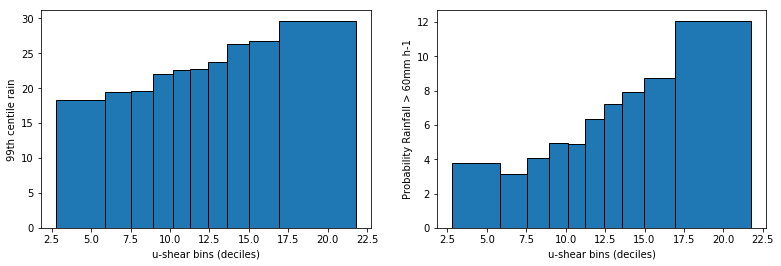

In [117]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, pprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

bar_dic = {
'xtick' : xtick,
'ytick' : pprob,
'width' : xtickwidth
}

Text(0,0.5,'Probability Rainfall > 60mm h-1')

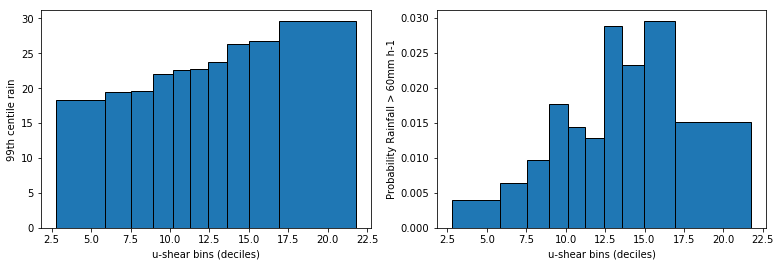

In [118]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, qqprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

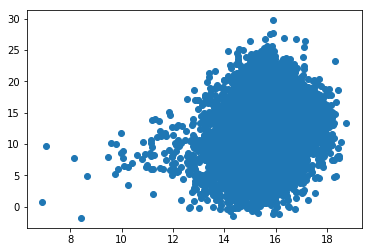

In [119]:
plt.scatter(obsp.q925, obsp.shear)

In [120]:
np.percentile(obsp.prcp[obsp.prcp>1],90)

51.62151925865162

[13.00446782 14.50392863 14.86698238 15.13584641 15.36407363 15.58911925
 15.84546641 16.15469427 16.60016759 18.75936799]
bigger than 13.004467822611332
smaller than 14.503928625749218
bigger than 14.503928625749218
smaller than 14.866982379721271
bigger than 14.866982379721271
smaller than 15.135846411188442
bigger than 15.135846411188442
smaller than 15.364073630836275
bigger than 15.364073630836275
smaller than 15.589119245608646
bigger than 15.589119245608646
smaller than 15.845466405153275
bigger than 15.845466405153275
smaller than 16.15469426744514
bigger than 16.15469426744514
smaller than 16.600167585743797
bigger than 16.600167585743797
smaller than 18.759367987513542


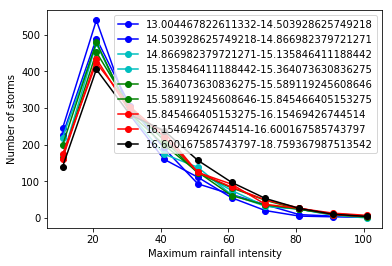

In [121]:
p = np.array(obsp.q925)
t = np.array(obsp.prcp)
q = np.array(obsp.shear)


bins = np.percentile(p[p>=13], np.linspace(0,100,10))#np.arange(4, 29, 2)  # compute probability per temperature range (1degC)
print(bins)
shearlist = []
pprob = []
qqprob = []
plist = []
#ax5 = fig.add_subplot(236)

colours = [ 'b', 'b',  'c', 'c', 'g', 'g', 'r', 'r', 'k', 'k']

for ids, c in enumerate(bins[0:-1]):
    pos = np.where((p >= c) & (p < bins[ids+1]))
    print('bigger than',c )
    print('smaller than', bins[ids+1])

    try:
        cmean = np.percentile(t[pos], 50)
    except IndexError:
        cmean = np.nan

    H, binz = np.histogram(t[pos], bins=np.arange(1,111,10))
    #H, bins = ustat.histo_frequency(t[pos])

    plt.plot(binz[0:-1]+(binz[1::]-binz[0:-1]), H, 'o-',  label=str(c)+'-'+str(bins[ids+1]) , color=colours[ids])

    prob = np.sum(t[pos]>55) / np.sum(t[pos]>1)
    qprob = np.sum(q[pos]>=18) / np.sum(q[pos]>=0)
    pprob.append(prob)
    qqprob.append(qprob)
    plist.append(cmean)
    shearlist.append(((bins[ids+1])-c)/2)

plt.xlabel('Maximum rainfall intensity')
plt.ylabel('Number of storms')
plt.plot()
plt.legend()
xtick = bins[0:-1]

xtickwidth= (bins[1::]-bins[0:-1])

Text(0,0.5,'Probability Rainfall > 60mm h-1')

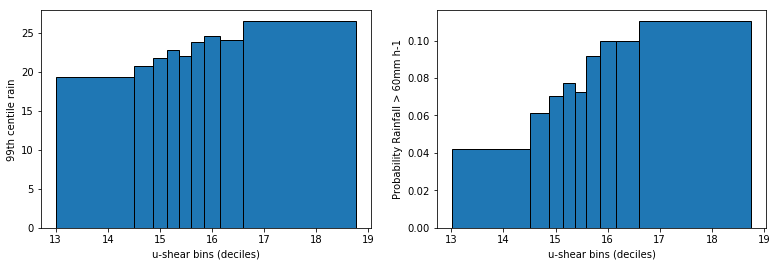

In [122]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, pprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

Text(0,0.5,'Probability Rainfall > 60mm h-1')

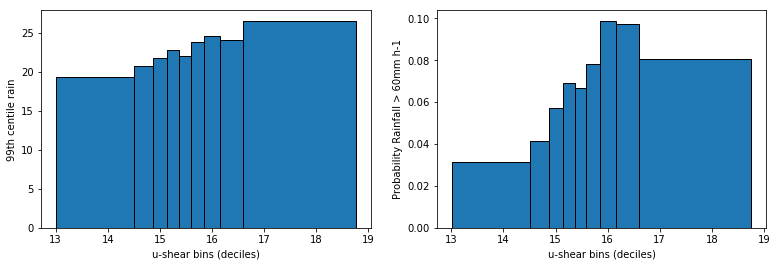

In [123]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, qqprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

In [124]:
u_stat.pcor(obsp.prcp, obsp.q925,obsp.shear)

(0.07944122687735919, 1.5710227946400746e-19)

In [125]:
u_stat.pcor(obsp.prcp, obsp.shear,obsp.q925)

(0.17682340942969743, 3.6353402379634784e-91)

In [126]:
def sort_vars():
    q925 = np.array(obsp.shear)
    shears = np.array(obsp.q925)

    sort = np.argsort(q925)
    q = q925[sort]

    shear = shears[sort]
    tmin = np.array(obsp.prcp)[sort]
    
    linsp = np.linspace(0,len(q925)-1,12)
    #linsp = np.percentile(q925[q925>=2], np.linspace(0,99,11))
    
    inds = np.round(linsp).astype(int)

    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    
    for start,end in enumerate(inds[2::]):  #
        #ipdb.set_trace()
        qsample = q[inds[start]:end]
        qmean.append( np.min(qsample)+ (np.max(qsample)-np.min(qsample))/2)
        
            

        ttslope, intercept, rc, p, std_err = linregress(shear[start:end],tmin[start:end])
        print(shear[inds[start]], shear[end])
#         ccslope, intercept, rt, p, std_err = linregress(q[start:end], shear[start:end])
#         corr.append(ttslope) 
        corr.append(rc)
        qcorr.append(ttslope) 
    return qmean, corr, qcorr

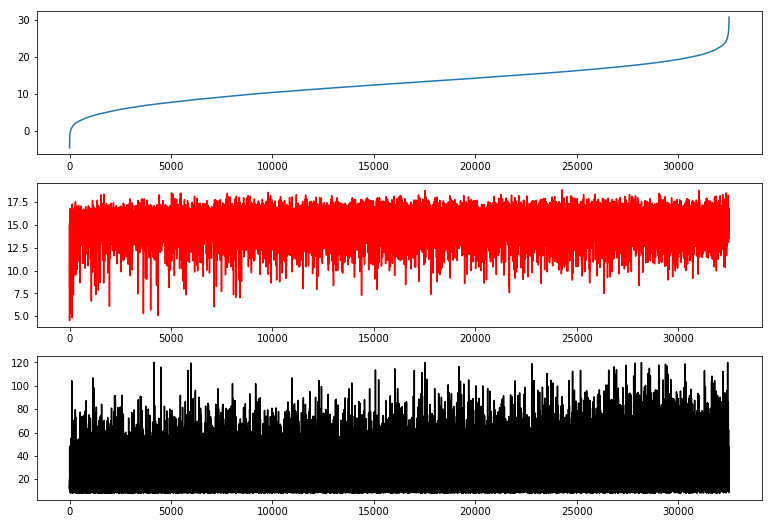

14.821389690041542 15.358157455921173
15.367282554507256 12.820682488381863
15.358157455921173 15.334469266235828
12.820682488381863 14.218268916010857
15.334469266235828 14.72728792577982
14.218268916010857 14.219649136066437
14.72728792577982 14.787157997488976
14.219649136066437 14.764728024601936
14.787157997488976 15.393808484077454
14.764728024601936 15.822088345885277


In [66]:
qmean, corr, slope = sort_vars()

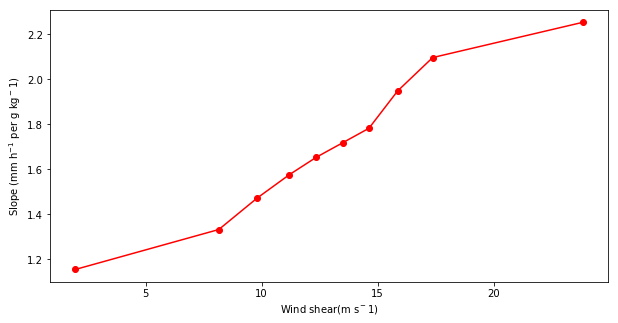

In [67]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.plot(qmean,slope, 'ro-')
ax.set_xlabel('Wind shear(m s$^-1$)')
ax.set_ylabel('Slope (mm h$^{-1}$ per g kg$^-1$)')
slope_dic = {
'xtick' : qmean,
'ytick' : slope,
}

Text(0,0.5,'Slope (mm h$^{-1}$ per g kg$^-1$)')

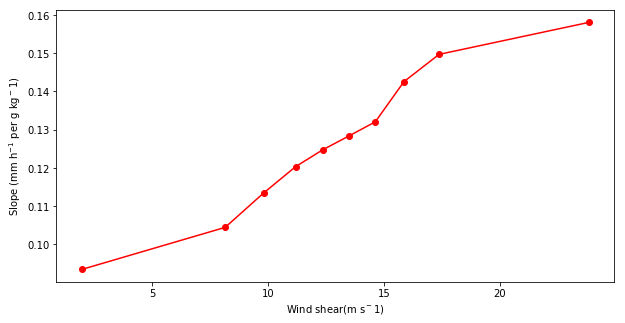

In [68]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.plot(qmean,corr, 'ro-')
ax.set_xlabel('Wind shear(m s$^-1$)')
ax.set_ylabel('Slope (mm h$^{-1}$ per g kg$^-1$)')

In [69]:
def hist2d_bar(data, bar, slope, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(5,10))
    text = ['(a)', '(b)', '(c)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(3,1,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    ax4 = f.add_subplot(313)
    ax4.bar(bar['xtick'], np.array(bar['ytick'])*100, bar['width'], align='edge', ec='black')
    ax4.set_xlabel('650-925hPa wind shear (m s$^{-1}$)')
    ax4.set_ylabel('Probability rainfall > 55mm h$^{-1}$ (%)')
    
    ax5 = ax4.twinx()
    ax5.plot(np.array(bar['xtick'])+np.array(bar['width'])/2,slope['ytick'], 'ko-') #np.array(bar['xtick'])+np.array(bar['width'])/2
    ax5.set_xlabel('Wind shear(m s$^-1$)')
    ax5.set_ylabel('Slope (mm h$^{-1}$ per g kg$^-1$)')
    


    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.97), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.02, 0.64), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[2], xy=(0.02, 0.315), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
#plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/fig_2dhist_obsOnly.png')

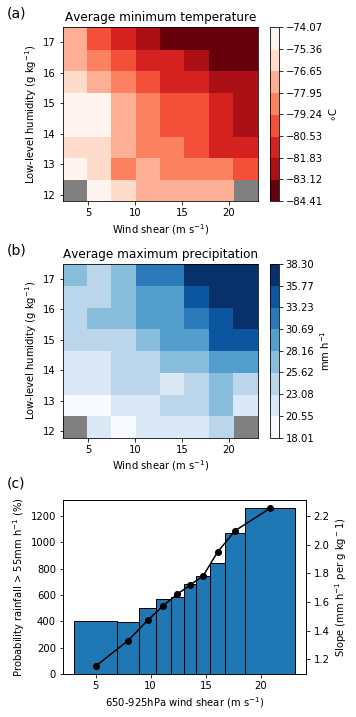

In [70]:
data_list = [tmin_dic, prcp_dic]
hist2d_bar(data_list, bar_dic, slope_dic, valid=False)

In [71]:
obs_gpm.keys()

Index(['prcp', 'u650', 'u925', 'q925', 'q650', 't925', 't650', 'shear',
       'month', 'area', 'tmin', 'tmean', 'theta', 'theta_e', 'lat', 'lon'],
      dtype='object')

In [72]:
dat = obs_gpm
data1, r1 = density_plot(dat.shear, dat.prcp, dat.q925)

plt.scatter(dat.shear, dat.prcp, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r

KeyboardInterrupt: 

In [184]:
rainlist = []
for rain in OBS['p']:
    
    rainlist.extend(rain.flat)

In [185]:
len(rainlist)
rain = np.array(rainlist)

In [186]:
np.percentile(rain[rain>1],95)

22.52128280644234

In [187]:
np.percentile(obs_gpm.prcp[obs_gpm.prcp>1],95)

57.75760822868769

In [188]:
dQ = pkl.load(open(cnst.network_data + 'data/CLOVER/saves/deltaQ_plot.p',
                           'rb'))

In [189]:
dQ

{'deltaqy': array([ 0.0501999 ,  0.03189941, -0.040171  ,  0.10085453,  0.19249202,
         0.3573268 ,  0.629571  ,  0.51972616,  0.45858485,  0.6206908 ],
       dtype=float32),
 'tminstd': array([-68.48999023, -69.314991  , -70.38499832, -70.79998779,
        -71.02999878, -71.72999573, -72.54499054, -73.13749695,
        -73.68998718, -74.25999451]),
 'tminx': array([ 5.566946,  7.212179,  8.460169,  9.554464, 10.559965, 11.570615,
        12.676903, 13.901707, 15.342691, 17.408857], dtype=float32),
 'tminy': array([-72.96999359, -74.12499237, -74.80499268, -75.18998718,
        -75.72999573, -76.48999023, -77.38999939, -78.33999634,
        -78.81999207, -79.39499664])}

In [190]:
x = np.array(dQ['tminx'])
corr_all = np.array(dQ['deltaqy'])

qcorr_all = np.array(dQ['tminy'])
qcorr_all_std = np.array(dQ['tminstd'])

In [194]:
def hist2d_deltaQ(data, bar, slope, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(10,7), dpi=300)
    text = ['(a)', '(b)', '(c)', '(d)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
        plt.plot(9.9,15.1,'ko')
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    ax4 = f.add_subplot(224)
    ax4.bar(bar['xtick'], np.array(bar['ytick'])*100, bar['width'], align='edge', ec='black', color='lightblue')
    ax4.set_xlabel('Wind shear (m s$^{-1}$)')
    ax4.set_ylabel('%')
    
    ax5 = ax4.twinx()
    ax5.plot(np.array(bar['xtick'])+np.array(bar['width'])/2,slope['ytick'], 'ko-') #np.array(bar['xtick'])+np.array(bar['width'])/2
    ax5.set_xlabel('Wind shear(m s$^-1$)')
    ax5.set_ylabel('mm h$^{-1}$ per g kg$^-1$')
    ax5.text(0.01,0.8,'Slope', color='k', transform=ax5.transAxes, fontsize=11)
    ax5.text(0.01,0.9,'Probability Rainfall > 55 mm h$^{-1}$', color='b', transform=ax5.transAxes, fontsize=11)
    
    ax6 = f.add_subplot(223)
    ax6.plot(x,corr_all, 'k-o', label='${\Delta}$q925')
    ax6.fill_between(x,corr_all-0.3, corr_all+0.3, color='b', alpha=0.05)
    ax7 = ax6.twinx()
    ax7.plot(x,qcorr_all, 'ro-', label='Minimum T')
    ax7.fill_between(x,qcorr_all-qcorr_all_std*0.05, qcorr_all+qcorr_all_std*0.05, color='r', alpha=0.05)
    #ax1.errorbar(x, qcorr_all, yerr=qcorr_all_std*0.05, fmt='.k');
    ax7.set_ylim(-85,-70)
    ax7.set_ylim(ax7.get_ylim()[::-1])
    ax6.set_xlabel('Wind shear (m s$^{-1}$)')
    ax6.set_ylabel('g kg$^{-1}$')
    ax7.set_ylabel(r'${\circ}$C')
    ax6.text(0.02,0.8,'${\Delta}$q925', color='k', transform=ax6.transAxes, fontsize=11)
    ax6.text(0.02,0.9,'Minimum temperature', color='r', transform=ax6.transAxes, fontsize=11)

    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.53, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[2], xy=(0.02, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[3], xy=(0.53, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/fig_2dhist_obsOnly_deltaQ.png')

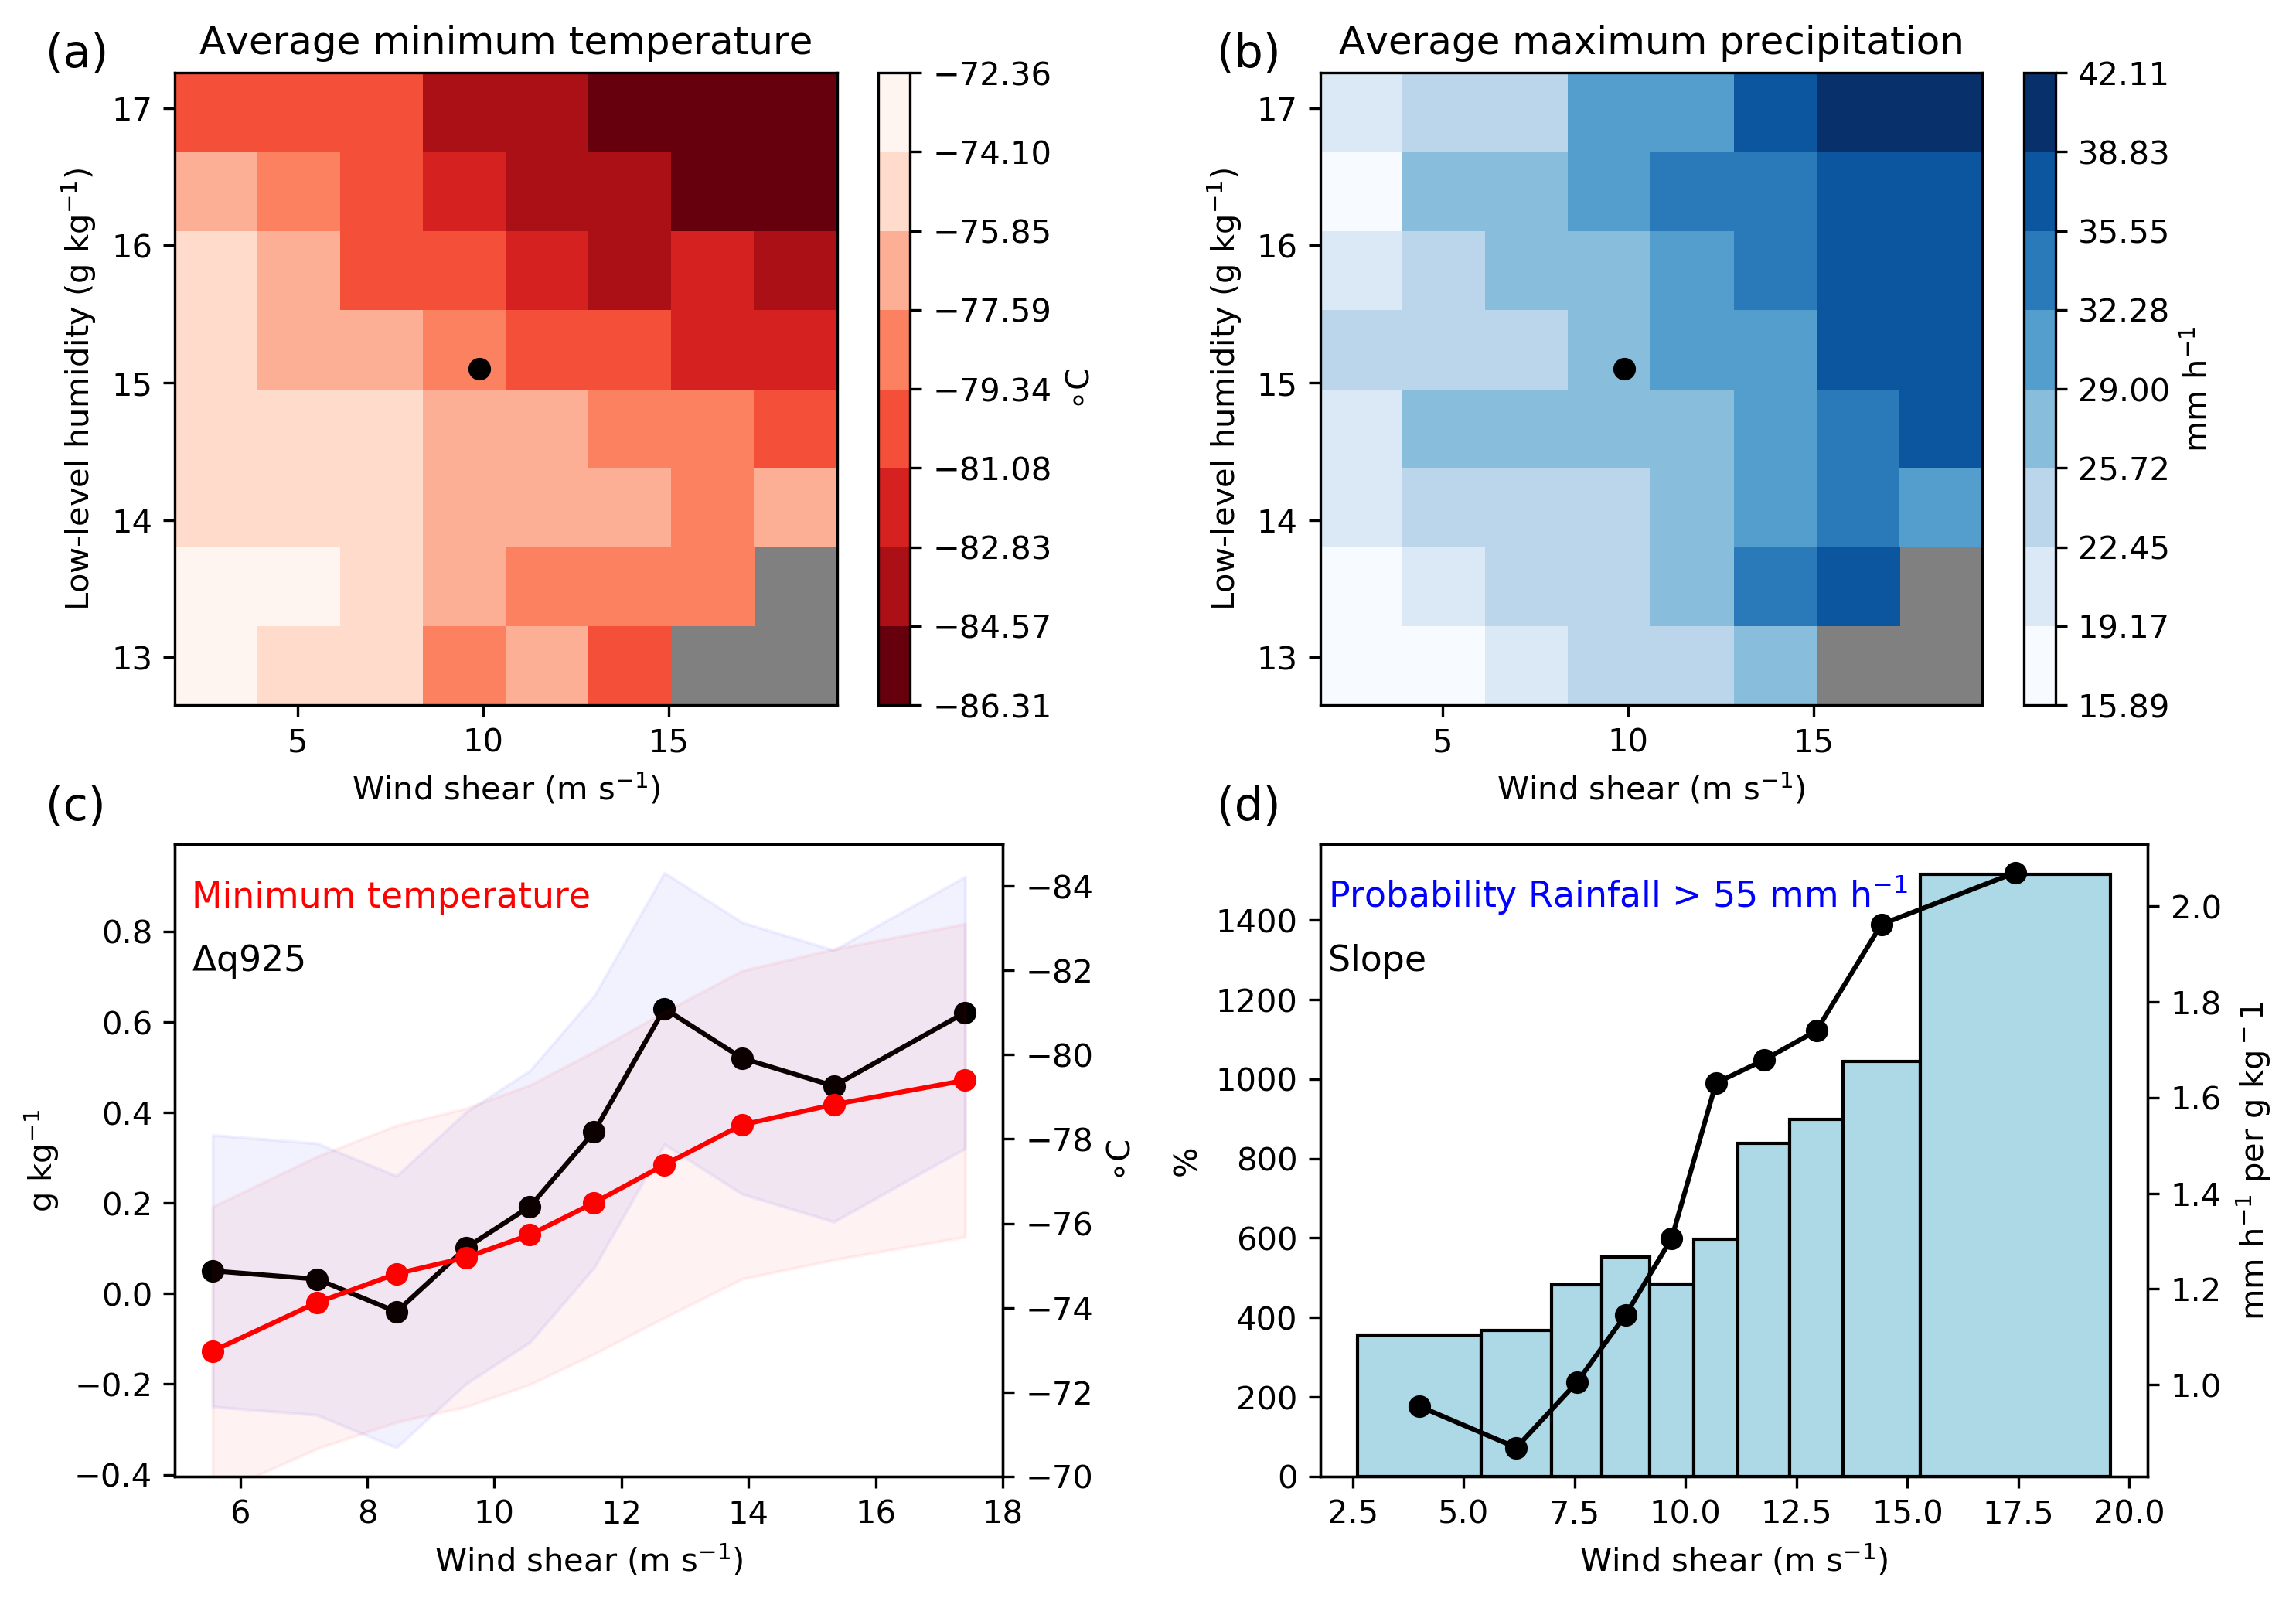

In [195]:
data_list = [tmin_dic, prcp_dic]
hist2d_deltaQ(data_list, bar_dic, slope_dic, valid=False)

In [198]:
def hist2d_deltaQ(data, box1, box2, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(10,7), dpi=300)
    text = ['(a)', '(b)', '(c)', '(d)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
        plt.plot(10.2,15.2,'ko')
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    ax4 = f.add_subplot(224)
    ax4.set_xlabel('Low-level humidity (g kg$^{-1}$)')
    ax4.set_ylabel('Average max. precipitation (mm h$^{-1}$)')
    
    bp = ax4.boxplot(box2[0], labels=box2[1], whis=3, patch_artist=True)
    for patch in (bp['boxes']):
        patch.set(facecolor='aliceblue')   
    
    ax6 = f.add_subplot(223)
    bp2 = ax6.boxplot(box1[0], labels=box1[1], whis=3, patch_artist=True)
    for patch in (bp2['boxes']):
        patch.set(facecolor='aliceblue')  
        
    ax6.set_xlabel('Wind shear (m s$^{-1}$)')
    ax6.set_ylabel('Average max. precipitation (mm h$^{-1}$)')
#     ax6.text(0.02,0.8,'${\Delta}$q925', color='k', transform=ax6.transAxes, fontsize=11)
#     ax6.text(0.02,0.9,'Minimum temperature', color='r', transform=ax6.transAxes, fontsize=11)

    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.53, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[2], xy=(0.02, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[3], xy=(0.53, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/fig_2dhist_obsOnly_boxplot.png')

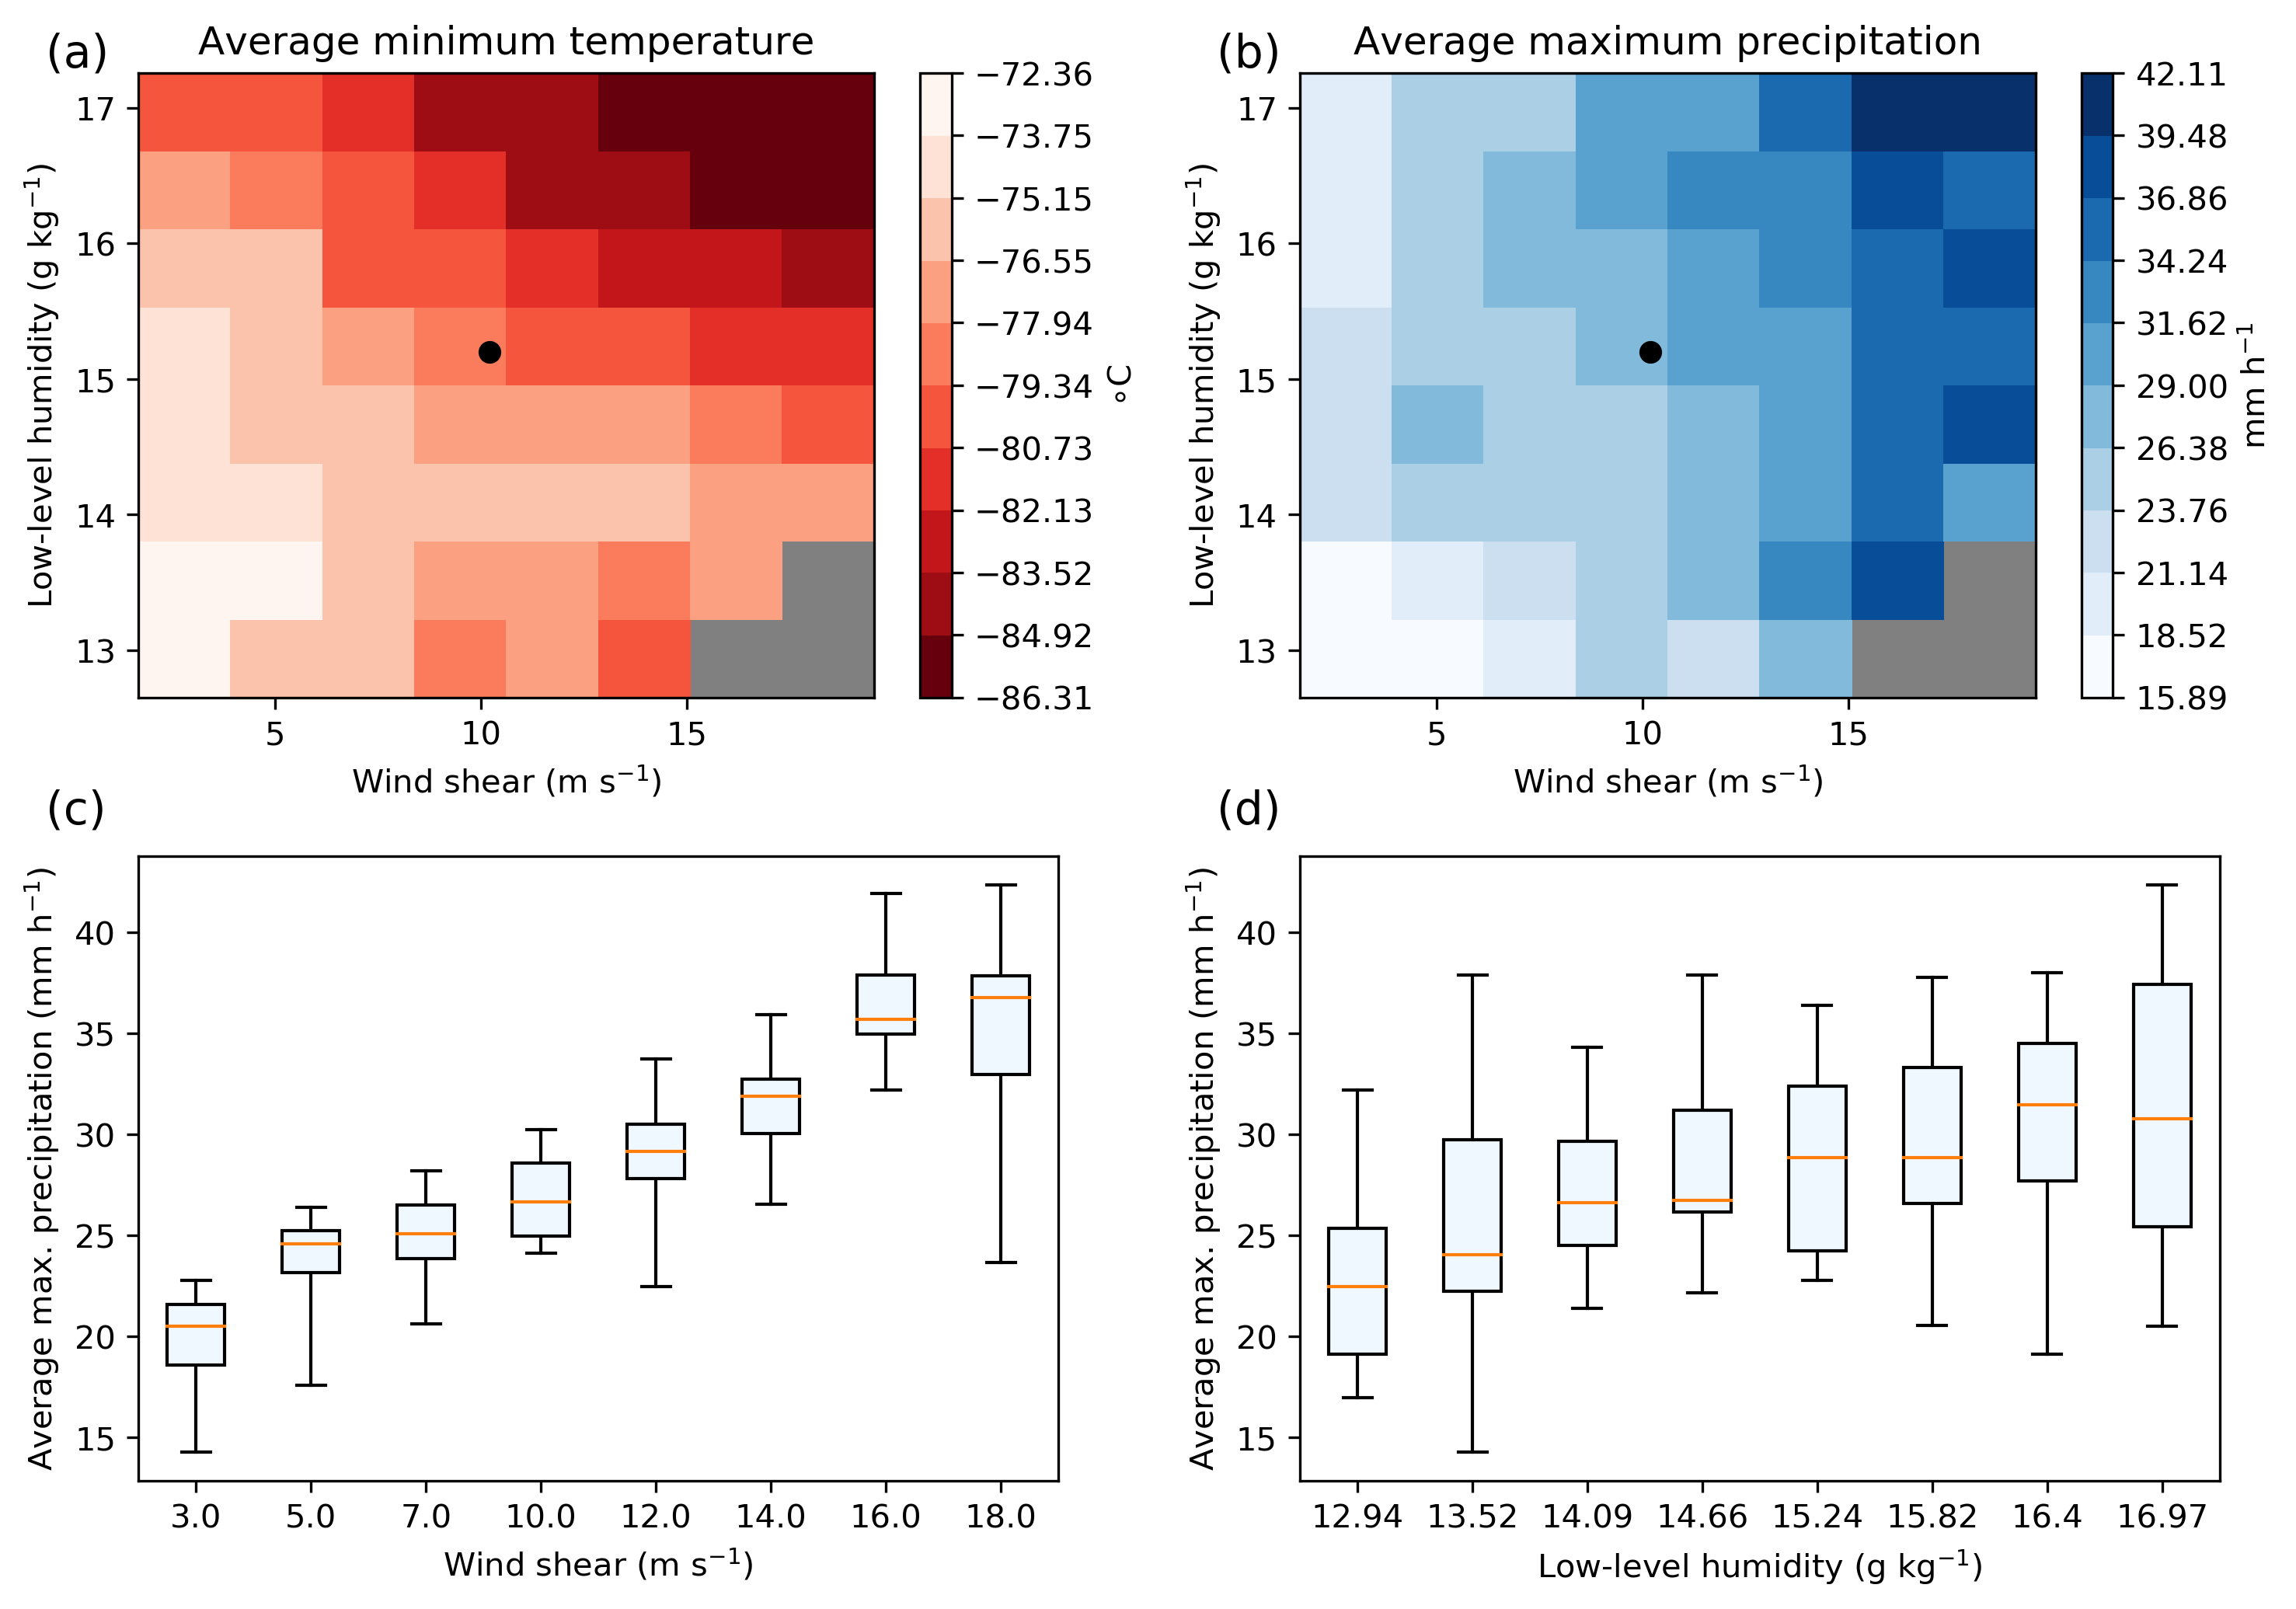

In [199]:
data_list = [tmin_dic, prcp_dic]
hist2d_deltaQ(data_list, box1, box2, valid=False)

In [817]:
def hist2d_deltaQ(data, bar, slope, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(10,4), dpi=300)
    text = ['(a)', '(b)', '(c)', '(d)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(1,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.93), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.53, 0.93), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    
 #   plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/2dHist.png')
        
 

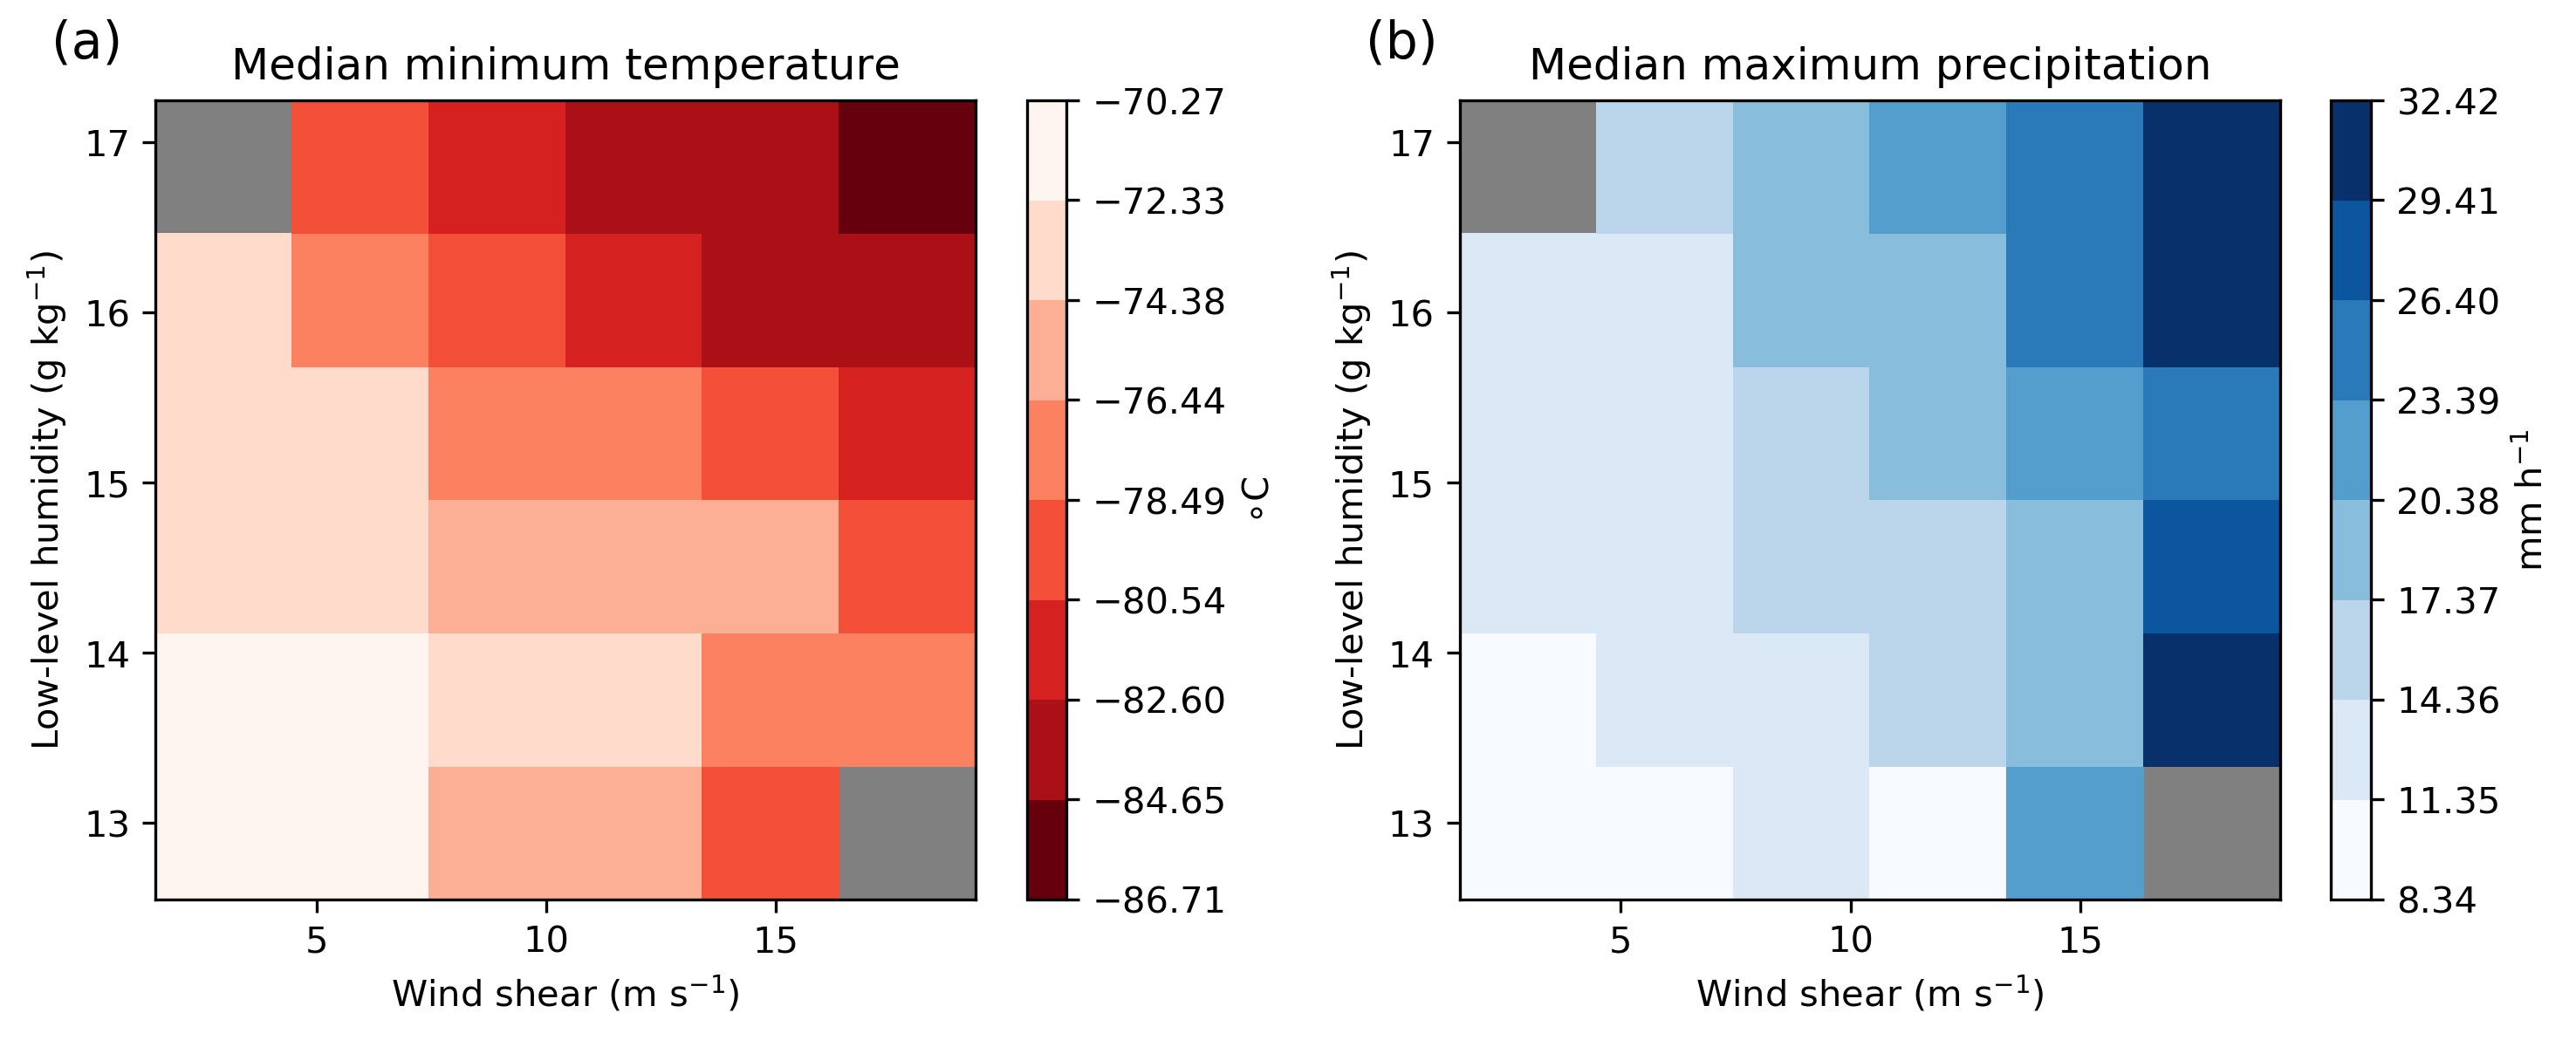

In [818]:
data_list = [tmin_dic, prcp_dic]
hist2d_deltaQ(data_list, bar_dic, slope_dic, valid=False)

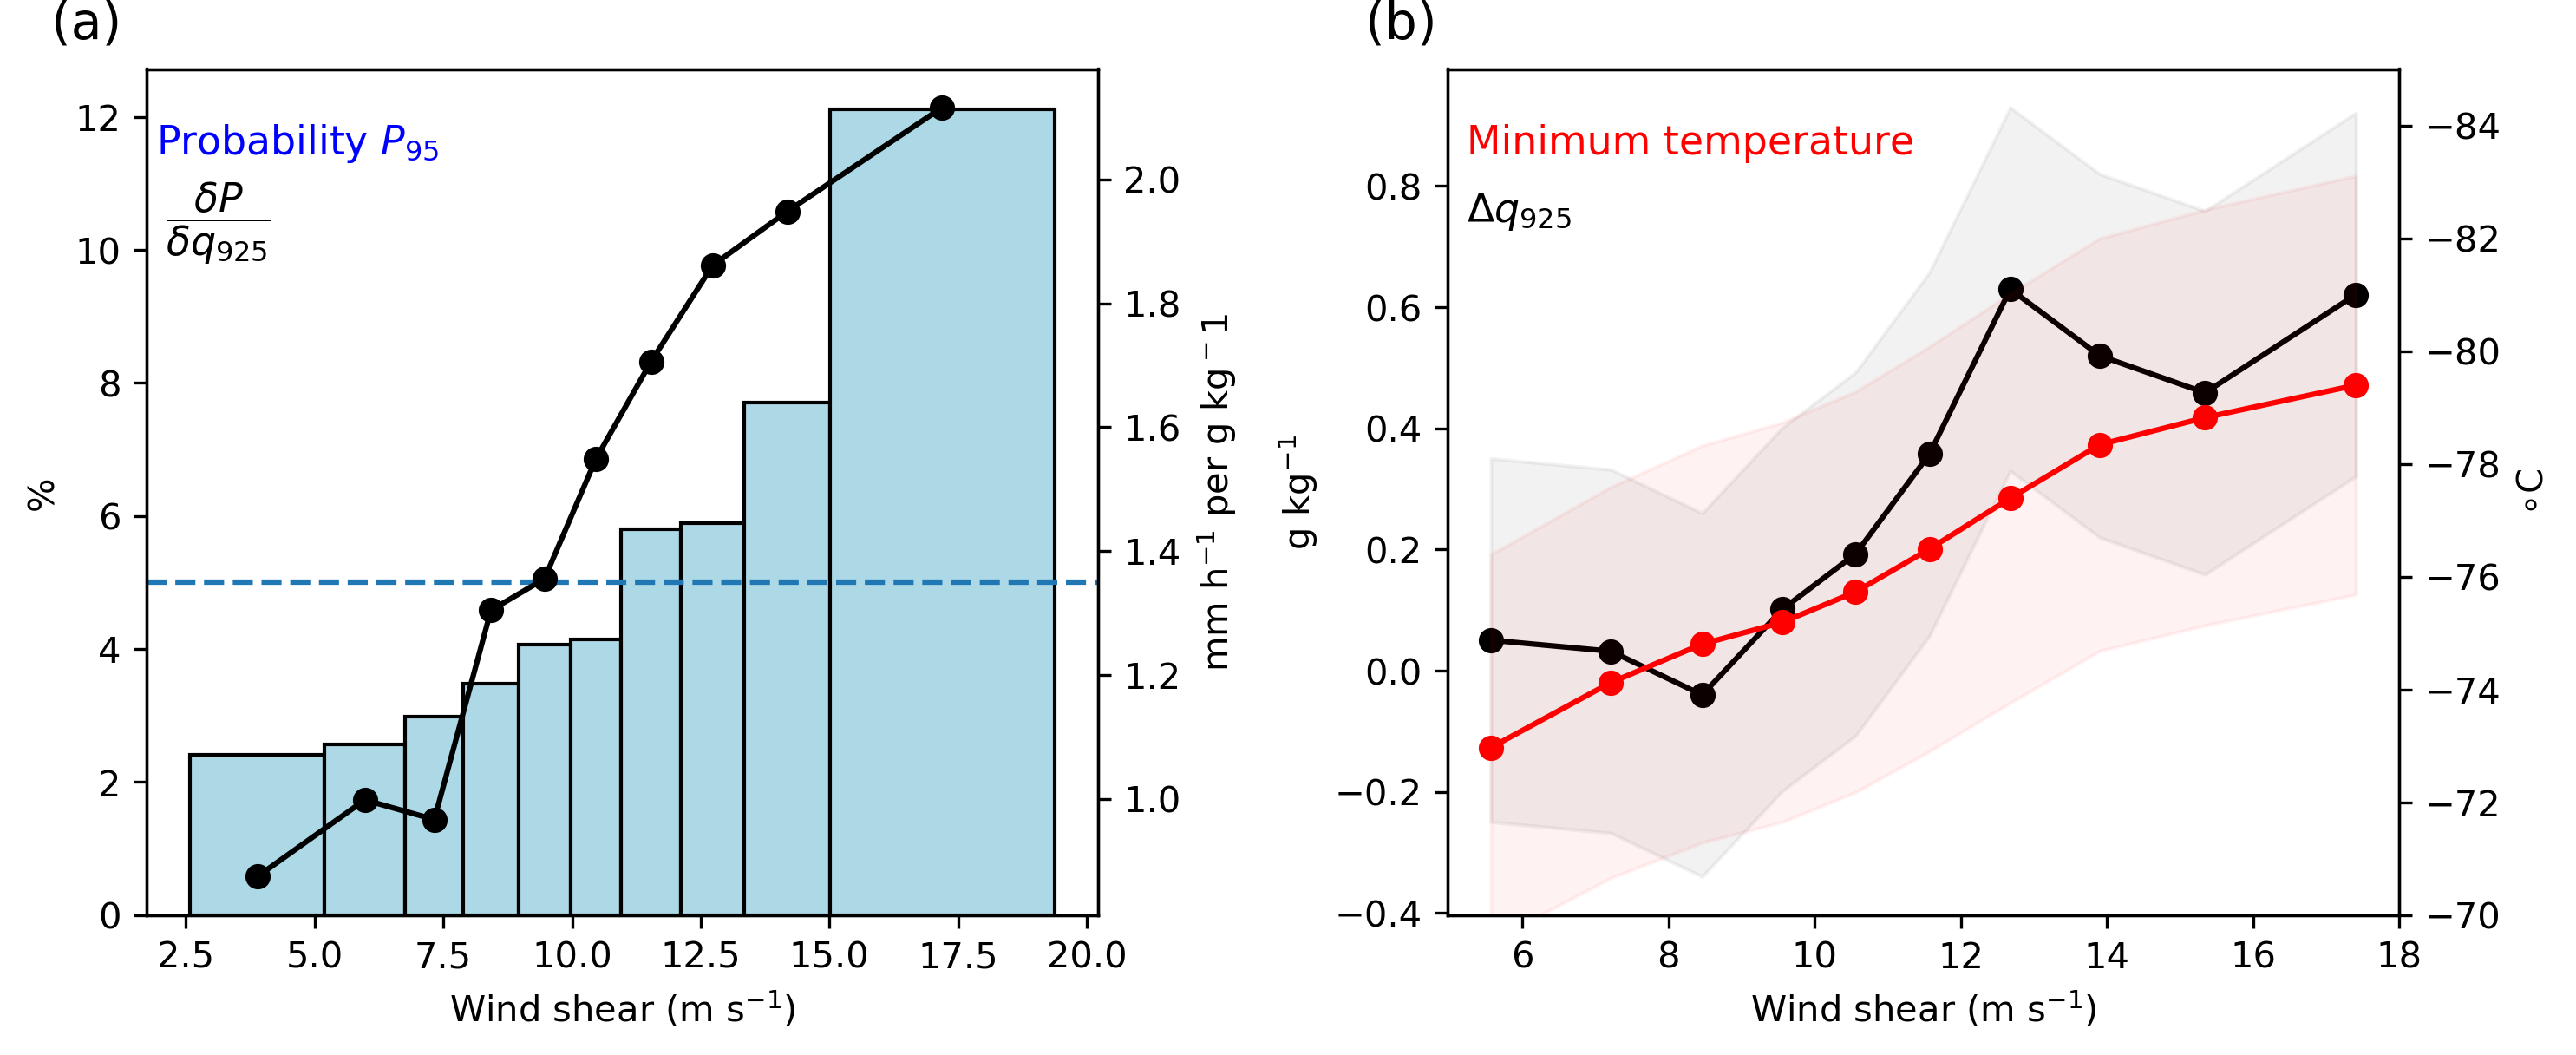

In [843]:
bar = bar_dic
slope = slope_dic

f = plt.figure(figsize=(10,4), dpi=300)
text = ['(a)', '(b)', '(a)', '(b)']
ax4 = f.add_subplot(121)
ax4.bar(bar['xtick'], np.array(bar['ytick']), bar['width'], align='edge', ec='black', color='lightblue')
ax4.set_xlabel('Wind shear (m s$^{-1}$)')
ax4.set_ylabel('%')

ax5 = ax4.twinx()
ax5.plot(np.array(bar['xtick'])+np.array(bar['width'])/2,slope['ytick'], 'ko-') #np.array(bar['xtick'])+np.array(bar['width'])/2
ax5.set_xlabel('Wind shear(m s$^-1$)')
ax5.set_ylabel('mm h$^{-1}$ per g kg$^-1$')
ax4.axhline(5, linestyle='dashed')
ax5.text(0.02,0.81,r'$\dfrac{\delta P}{\delta q_{925}}$', color='k', transform=ax5.transAxes, fontsize=11)
ax5.text(0.01,0.9,'Probability $P_{95}$', color='b', transform=ax5.transAxes, fontsize=11)

ax6 = f.add_subplot(122)
ax6.plot(x,corr_all, 'k-o', label='${\Delta}q_{925}$')
ax6.fill_between(x,corr_all-0.3, corr_all+0.3, color='k', alpha=0.05)
ax7 = ax6.twinx()
ax7.plot(x,qcorr_all, 'ro-', label='Minimum T')
ax7.fill_between(x,qcorr_all-qcorr_all_std*0.05, qcorr_all+qcorr_all_std*0.05, color='r', alpha=0.05)
#ax1.errorbar(x, qcorr_all, yerr=qcorr_all_std*0.05, fmt='.k');
ax7.set_ylim(-85,-70)
ax7.set_ylim(ax7.get_ylim()[::-1])
ax6.set_xlabel('Wind shear (m s$^{-1}$)')
ax6.set_ylabel('g kg$^{-1}$')
ax7.set_ylabel(r'${\circ}$C')
ax6.text(0.02,0.82,'${\Delta}q_{925}$', color='k', transform=ax6.transAxes, fontsize=11)
ax6.text(0.02,0.9,'Minimum temperature', color='r', transform=ax6.transAxes, fontsize=11)

plt.tight_layout()
plt.annotate(text[2], xy=(0.02, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points')
plt.annotate(text[3], xy=(0.53, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points')
plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/2dHist_new.png')